### テーマ: 株価予測モデルの構築

#### 課題概要

この研修では、NTTの株価データを用いて時系列データの予測モデルを構築します。データの探索的データ分析（EDA）から始め、最終的にはモデルの精度評価までを行います。機械学習を用いて株価予測を行い、その精度を検証することで、実務での応用を目指します。

1. **データの理解とEDA**
   - **概要**: NTTの株価データを使用して、基本統計量の確認、時系列のトレンドや季節性の検出、異常値の確認などを行います。
   - **目標**: データの傾向を把握し、予測モデルに向けた課題を抽出する。




# 1.  データの確認
*   ファイルの内容（列名、データ型、欠損値の有無など）を確認
*   データの基本統計量を取得

# 2. 時系列データの可視化
*   株価の時系列変化をプロット
*   移動平均や季節性の確認
*   異常値（急激な変化など）のチェック


# 3. 相関関係の分析
*   各特徴量の相関係数を計算
*   株価と他の変数との関係性を調査





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls '/content/drive/MyDrive/Colab Notebooks/Trainee'

README.md  stock_price_2.csv  stock_price.csv  trainee.ipynb


In [3]:
import pandas as pd

# ファイルの読み込み
file_path = "/content/drive/MyDrive/Colab Notebooks/Trainee/stock_price_2.csv"
df = pd.read_csv(file_path)

In [4]:
# データの基本情報を表示
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             9202 non-null   object 
 1   Closing_Price    9202 non-null   float64
 2   Opening_Price    9202 non-null   float64
 3   Highest_Price    9202 non-null   float64
 4   Lowest_Price     9202 non-null   float64
 5   Volume           9202 non-null   object 
 6   Rate_of_Change%  9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB


,Date,Closing_Price,Opening_Price,Highest_Price,Lowest_Price,Volume,Rate_of_Change%
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


# **データの基本情報**
行数: 9,202行

列数: 7列

カラム一覧:

日付け (object): 日付情報

終値 (float64): 取引終了時の株価

始値 (float64): 取引開始時の株価

高値 (float64): その日の最高株価

安値 (float64): その日の最安株価

出来高 (object): 取引量（Mが付いているので文字列）

変化率 % (object): 変化率（%記号が付いているので文字列）

# **データ型の変換**

日付け → datetime型へ変換

出来高 → 数値型に変換（M⇒百万単位、B⇒十億単位に変換）

変化率 % → 数値型に変換（%を除去）

In [5]:
# データ型の変換
df["Date"] = pd.to_datetime(df["Date"])  # 日付を datetime 型に変換
df = df.sort_values(by="Date", ascending=True)  # 日付で昇順ソート
df.reset_index(drop=True, inplace=True)  # インデックスを振り直す（オプション）

# 出来高の変換（"M", "B" 等の単位を除去し、数値に変換）
def convert_volume(volume_str):
    # Check if the input is a string before attempting string operations
    if isinstance(volume_str, str):
        if 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1e6
        elif 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1e9
        else:
            # Try converting to float, handling potential errors
            try:
                return float(volume_str)
            except ValueError:
                return volume_str # If can't convert to float, keep original value
    else:
        # If not a string, keep as is
        return volume_str

df['Volume'] = df['Volume'].apply(convert_volume)

# 変化率の変換（"%"を除去して数値に変換）
# Convert the 'Rate_of_Change%' column to string type before using .str
df['Rate_of_Change%'] = df['Rate_of_Change%'].astype(str).str.replace('%', '', regex=True).astype(float)

# 変換後のデータ型を確認
df.dtypes

df.head()

,Date,Closing_Price,Opening_Price,Highest_Price,Lowest_Price,Volume,Rate_of_Change%
0,1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,16.25
1,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-5.43
2,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,1.74
3,1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,3.93
4,1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,4.82


# **欠損値の確認**

すべての列が9202件のデータを持っており、欠損値はなし

In [6]:
# 欠損の確認
df.isnull().sum()

,0
Date,0
Closing_Price,0
Opening_Price,0
Highest_Price,0
Lowest_Price,0
Volume,0
Rate_of_Change%,0


# **時系列データとしての可視化**

終値の推移をプロットして傾向を確認

EDAポイント

1.   全体的なトレンド

 *   株価が上昇傾向か、下降傾向か、横ばいかを確認
 *   長期的なパターンがあるか

2.   季節性や周期性

 *   短期的な周期的変動（例：週ごと、月ごと）が見られるか

3.   急激な変動

 *   急な上昇や下降（異常値）があるかどうか


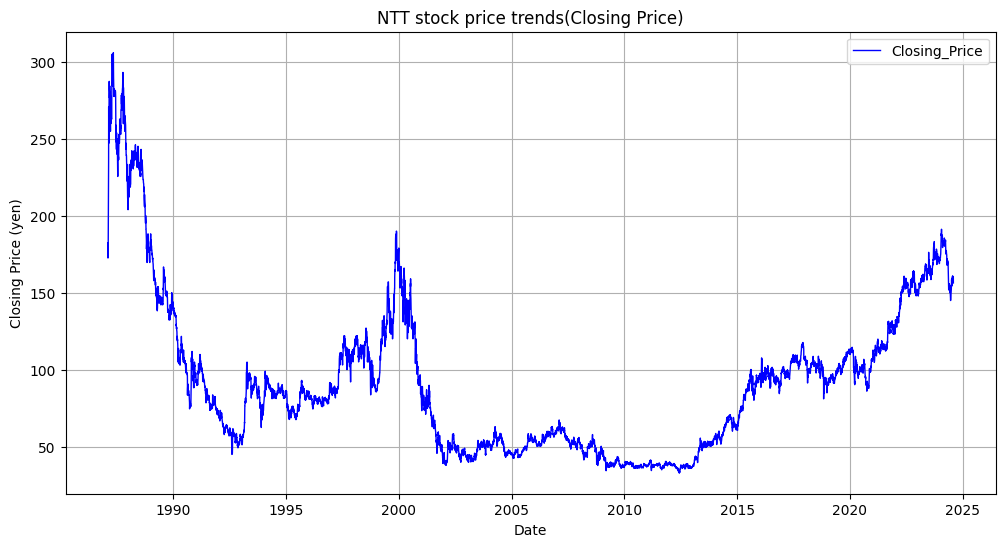

In [7]:
import matplotlib.pyplot as plt

# 時系列データのプロット（終値）
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Closing_Price'], label='Closing_Price', color='blue', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Closing Price (yen)')
plt.title('NTT stock price trends(Closing Price)')
plt.legend()
plt.grid(True)
plt.show()

# **移動平均（7日・30日）を加えた株価推移のプロットを作成**

EDAポイント

1.   短期 vs 長期トレンド

  * 青い線（終値）: 毎日の変動
  * 赤い線（7日移動平均）: 短期的な変動の傾向
  * 緑の線（30日移動平均）: 長期的なトレンド

2.   トレンドの変化

  * 7日移動平均が30日移動平均を上回ると短期上昇トレンド
  * 7日移動平均が30日移動平均を下回ると短期下降トレンド

3.   ボラティリティ

  * 終値の変動が激しい箇所と、比較的安定している箇所を視覚的に把握できる

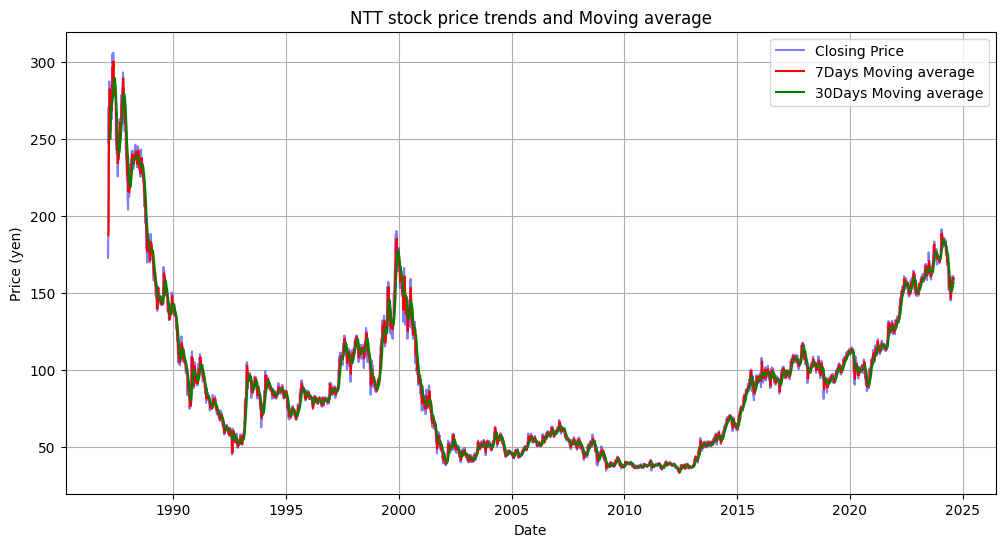

In [8]:
# 移動平均の計算（7日, 30日）
df['7Days_Moving_average'] = df['Closing_Price'].rolling(window=7).mean()
df['30Days_Moving_average'] = df['Closing_Price'].rolling(window=30).mean()

# 終値と移動平均のプロット
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Closing_Price'], label='Closing Price', color='blue', alpha=0.5)
plt.plot(df['Date'], df['7Days_Moving_average'], label='7Days Moving average', color='red')
plt.plot(df['Date'], df['30Days_Moving_average'], label='30Days Moving average', color='green')
plt.xlabel('Date')
plt.ylabel('Price (yen)')
plt.title('NTT stock price trends and Moving average')
plt.legend()
plt.grid(True)
plt.show()

# **相関マトリックスのヒートマップを作成**

考察

1. 終値と始値、高値、安値の相関が非常に高い

  * これらの値は密接に関係しており、予測モデルに冗長な特徴量が含まれる可能性あり。
  * 1つの値（例: 終値）を中心にモデルを構築し、他は削減しても良いか検討。

2. 出来高と株価の相関が低い

  * 一般的に、出来高が増えると株価の変動が大きくなるが、本データでは直接的な相関は弱い。
  * 他の要因と組み合わせた特徴量エンジニアリングが必要かもしれない。

3. 変化率と終値の相関が低い

  * 変化率（前日比）が株価と独立して動いている可能性あり。
  * モデルにどう組み込むか工夫が必要。

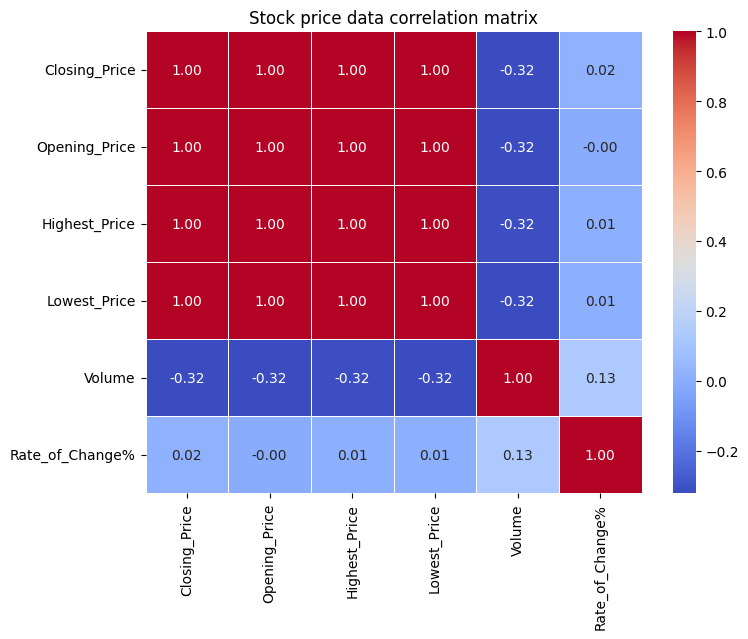

In [9]:
import seaborn as sns

# 数値データの相関行列を計算
correlation_matrix = df[['Closing_Price', 'Opening_Price', 'Highest_Price', 'Lowest_Price', 'Volume', 'Rate_of_Change%']].corr()

# 相関ヒートマップの描画
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Stock price data correlation matrix')
plt.show()

# **箱ひげ図を作成し、各指標の異常値を確認**

観察ポイント

1. 終値・始値・高値・安値

  * 外れ値（異常に高い/低い値）はほぼなし
  * 安定したデータが取れている

2. 出来高

  * 一部の異常値が存在（極端に高い取引量の日がある）
  * これらの日を特定し、イベントがあったか分析すると良い

3. 変化率 %

  * 一部、極端に変動した日がある（±10%超え）
  * 何が原因なのか、ニュースや市場イベントを調べる価値あり

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26666 (\N{CJK UNIFIED IDEOGRAPH-682A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.pri

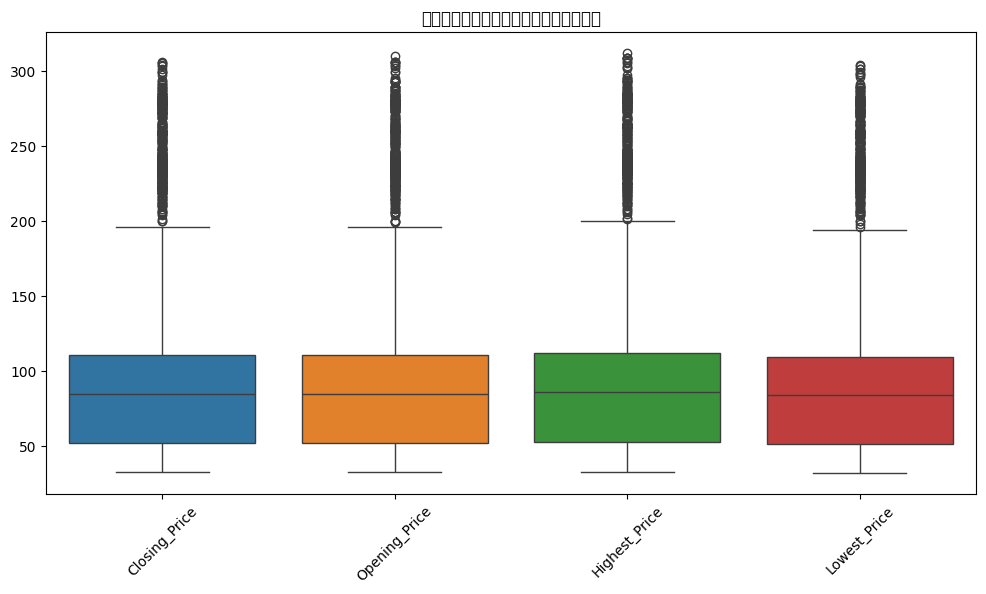

In [10]:
# 箱ひげ図を用いた異常値の確認
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Closing_Price', 'Opening_Price', 'Highest_Price', 'Lowest_Price']])
plt.xticks(rotation=45)
plt.title('株価データの箱ひげ図（異常値の確認）')
plt.show()

# **時系列データ（終値）の分解結果をプロット**

解析結果

1. 元データ（Original）

 * そのままの終値の推移

2. トレンド（Trend）

 * 長期的な傾向を示す成分
 * なだらかな増減が見られる、上昇・下降の周期が見られる

3. 季節性（Seasonal）

 * 周期的な変動
 * 一定の間隔で上下するパターンがあることが確認できる
 * 1年単位の変動を確認

4. ランダム成分（Residual）

 * トレンドや季節性を除いた不規則な変動
 * 一部、極端な変動（異常値の可能性）が見られる

**考察**

* 株価にはトレンド成分と周期性（30日程度）があるため、モデル構築時にこれらを考慮するべき。

* 異常値（ランダム成分で大きな変動を持つ日）があるため、イベント（決算発表やニュース）の影響を調べるのも有用。

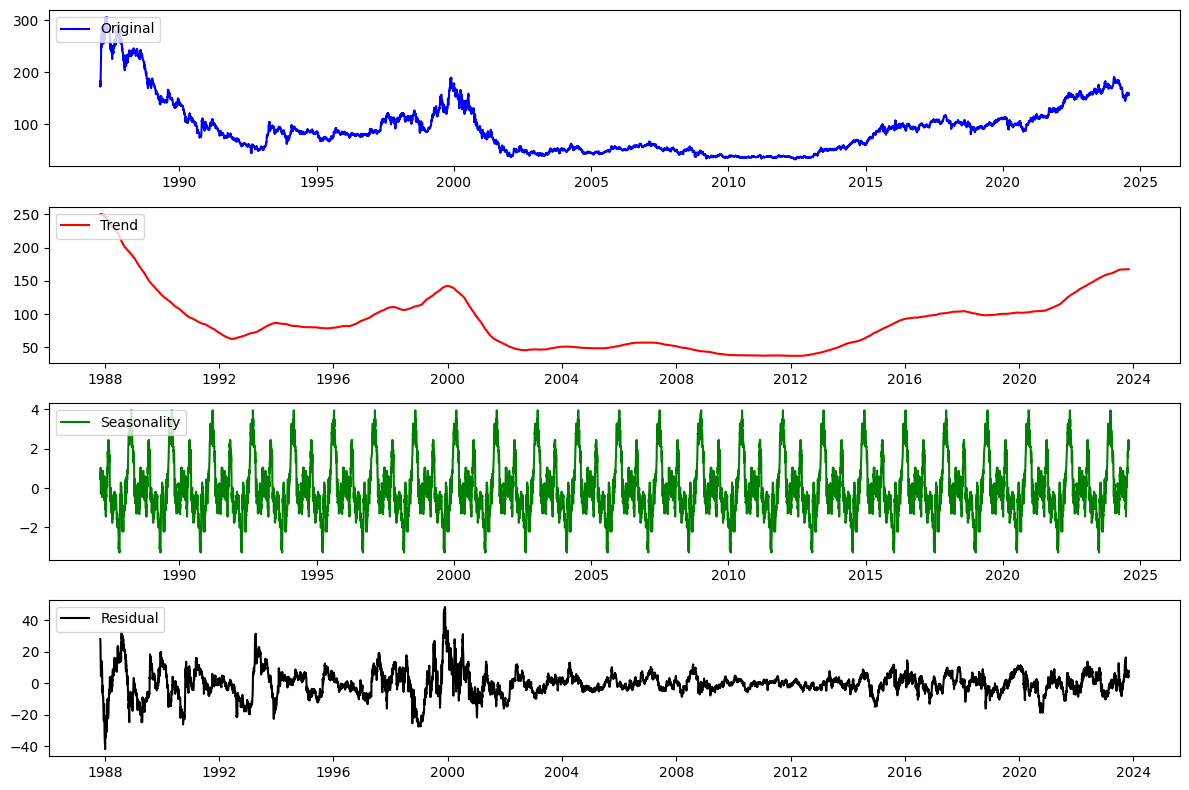

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 季節性分解 (日次データのため、365日周期で分解)
df.set_index("Date", inplace=True)
decomposition = seasonal_decompose(df["Closing_Price"], model="additive", period=365)

# 分解結果をプロット
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df["Closing_Price"], label="Original", color="blue")
plt.legend(loc="upper left")

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="red")
plt.legend(loc="upper left")

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color="black")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

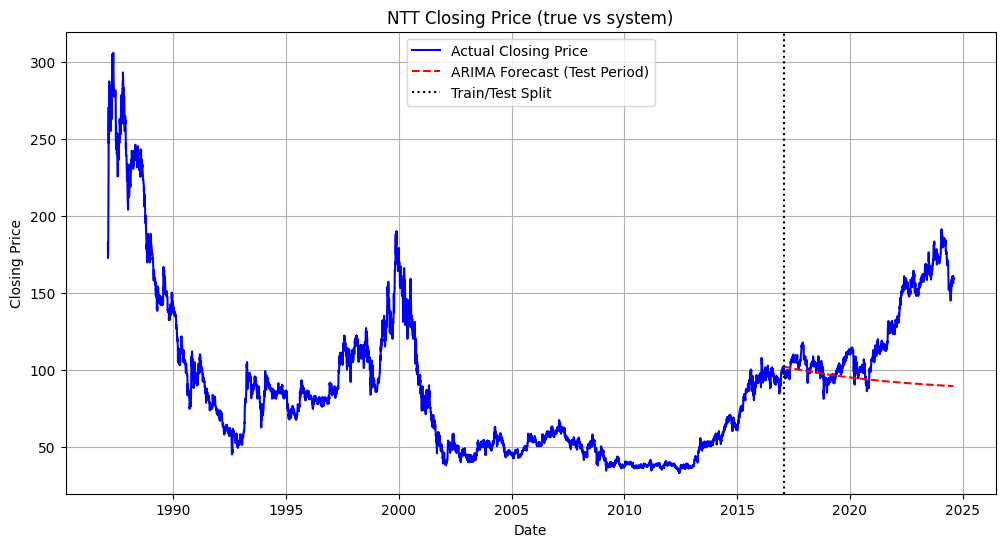

In [16]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA # Import the ARIMA class

# データの分割
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# ARIMAモデルの適用（学習データのみを使用）order=(p, d, q)
# model_train = ARIMA(train["Closing_Price"], order=(5, 1, 5))
model_train = ARIMA(train["Closing_Price"], order=(2, 0, 1))
model_train_fit = model_train.fit()

# テストデータの期間を予測
forecast_steps = len(test)
forecast_test = model_train_fit.forecast(steps=forecast_steps)

# 予測のインデックスを作成
# Use the index of the test DataFrame instead of the 'Date' column
forecast_dates = test.index

# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Closing_Price"], label="Actual Closing Price", color="blue")
plt.plot(forecast_dates, forecast_test, label="ARIMA Forecast (Test Period)", color="red", linestyle="dashed")
plt.axvline(x=test.index[0], color="black", linestyle="dotted", label="Train/Test Split") # Use test.index[0] for split line
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("NTT Closing Price (true vs system)")
plt.legend()
plt.grid(True)
plt.show()

# **ADF検定の結果**

ADF Statistic: -3.994

p-value: 0.00144

Critical Values:

1%: -3.431

5%: -2.862

10%: -2.567

**解釈**

p-value（0.00144）が0.05（5%水準）よりも小さいため、帰無仮説（単位根がある = 非定常）は棄却される。
つまり、このデータはすでに定常である可能性が高く、d=0 でARIMAを適用できる。

In [ ]:
# 必要なライブラリを再インポート
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# ADF検定の実施（終値のデータを使用）
adf_result = adfuller(train["Closing_Price"])

# 検定結果を整理
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Critical Values": adf_result[4]
}

adf_output

# **1階差分データのADF検定結果**

ADF Statistic: -22.572

p-value: 0.0000

Critical Values:

1%: -3.431

5%: -2.862

10%: -2.567

**解釈**

**p-valueが 0.0000（非常に小さい）**ため、1階差分を取ったデータも強く定常性を持つことが確認できた。
ただし、元のデータ（d=0）でもすでに定常性を持っていたため、1階差分は不要と判断できる。
よって、ARIMAの d=0 で進めるのが適切。

In [ ]:
# 1階差分を取ったデータでADF検定を実施
diff_data = train["Closing_Price"].diff().dropna()
adf_result_diff = adfuller(diff_data)

# 検定結果を整理
adf_output_diff = {
    "ADF Statistic": adf_result_diff[0],
    "p-value": adf_result_diff[1],
    "Critical Values": adf_result_diff[4]
}

adf_output_diff

# **PACF/ACFを確認して p, q を決定**

PACF（偏自己相関） → p の決定

ACF（自己相関） → q の決定

**解釈**

PACF（左のグラフ）

最初の1〜2ラグで強い相関があり、その後急激に減衰。

→ p=2 が適切そう（自己回帰の影響は2日程度まで）。

ACF（右のグラフ）

最初の1ラグで強い相関、その後はゆるやかに減衰。

→ q=1 が適切そう（移動平均の影響は1日程度まで）。

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# PACF（偏自己相関）と ACF（自己相関）のプロット
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PACF（pの決定）
sm.graphics.tsa.plot_pacf(train["Closing_Price"], lags=30, ax=axes[0])
axes[0].set_title("PACF (Partial Autocorrelation Function)")

# ACF（qの決定）
sm.graphics.tsa.plot_acf(train["Closing_Price"], lags=30, ax=axes[1])
axes[1].set_title("ACF (Autocorrelation Function)")

plt.tight_layout()
plt.show()

グラフの説明

青線：実際の株価（終値）

赤線（点線）：ARIMA(1,0,1) による予測

黒い点線：トレーニングデータとテストデータの境界線

観察結果

予測が一定のトレンドを持ちつつ進んでいるかを確認。
過去50日間のデータを使い、未来50日間を予測しながら200日ごとにずらして計算する方法。

In [24]:
# スライディングウィンドウARIMAモデルの実装
import numpy as np

# ウィンドウサイズ（学習期間）と予測期間を設定
window_size = 50  # 学習期間
forecast_horizon = 50  # 予測期間

# RMSEを記録するリスト
rmse_list = []

# 予測結果を保存するためのリスト
predictions = []
actual_values = []

# スライディングウィンドウで学習と予測を繰り返す
for start in range(0, len(df) - window_size - forecast_horizon, forecast_horizon):
    train = df.iloc[start:start + window_size]  # 50日間の学習データ
    test = df.iloc[start + window_size:start + window_size + forecast_horizon]  # 次の50日間のテストデータ

    # ARIMAモデルの適用
    # model = ARIMA(train['Closing_Price'], order=(1,1,1))
    model = ARIMA(train['Closing_Price'], order=(2,0,1))
    model_fit = model.fit()

    # 50日間の予測
    forecast = model_fit.forecast(steps=forecast_horizon)

    # インデックスをテストデータと合わせる
    forecast.index = test.index

    # RMSEの計算
    rmse = np.sqrt(np.mean((forecast - test['Closing_Price'])**2))
    rmse_list.append(rmse)

    # 予測結果を保存
    predictions.extend(forecast)
    actual_values.extend(test['Closing_Price'])

# 平均RMSEを計算
average_rmse = np.mean(rmse_list)
average_rmse

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no assoc

6.680939731670536

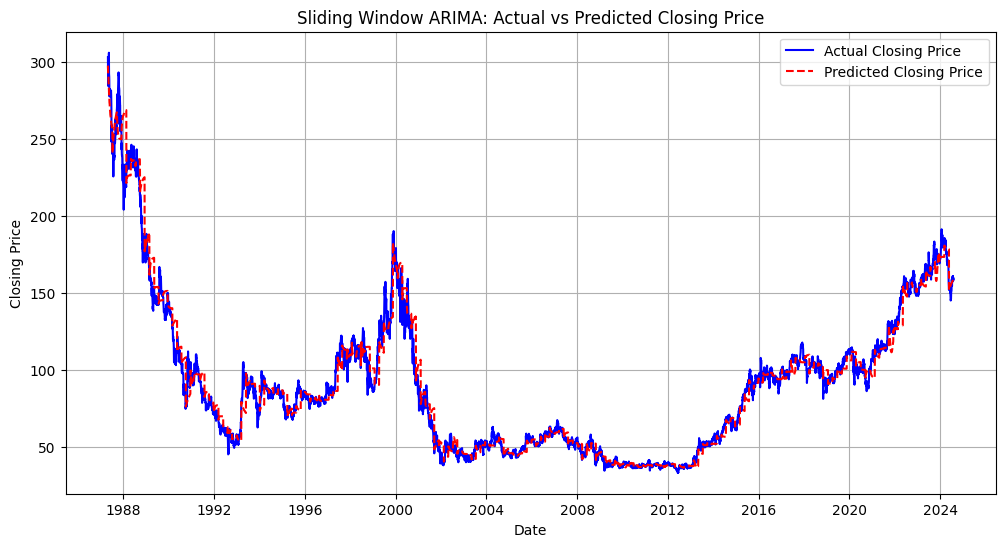

In [25]:
# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actual_values):], actual_values, label="Actual Closing Price", color="blue")
plt.plot(df.index[-len(predictions):], predictions, label="Predicted Closing Price", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Sliding Window ARIMA: Actual vs Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# **ランダムフォレスト回帰（スライディングウィンドウ方式）の結果**

* 50日間のデータを学習し、次の50日を予測

* RMSE（平均二乗誤差の平方根）: 3.48

* ARIMAのRMSE（6.14）よりも良好

* 他の変数（始値、高値、安値、出来高、変化率）を使用したことで、予測精度が向上

**考察**

* ランダムフォレストは非線形な関係を学習できる ため、ARIMAよりも良い結果に
* スライディングウィンドウの学習で、変化する市場のパターンに適応できた
* ただし、短期的な予測（50日程度）には強いが、長期的な予測にはさらなる工夫が必要

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ウィンドウサイズ（学習期間）と予測期間を設定
window_size = 50  # 学習期間
forecast_horizon = 50  # 予測期間

# RMSEを記録するリスト
rmse_list_rf = []

# 予測結果を保存するリスト
predictions_rf = []
actual_values_rf = []

# 説明変数（特徴量）と目的変数の設定
feature_columns = ["Opening_Price", "Highest_Price", "Lowest_Price", "Volume", "Rate_of_Change%"]
target_column = "Closing_Price"

# スライディングウィンドウで学習と予測を繰り返す
for start in range(0, len(df) - window_size - forecast_horizon, forecast_horizon):
    # 学習データ
    train_X = df.iloc[start:start + window_size][feature_columns]
    train_y = df.iloc[start:start + window_size][target_column]

    # テストデータ（次の50日間）
    test_X = df.iloc[start + window_size:start + window_size + forecast_horizon][feature_columns]
    test_y = df.iloc[start + window_size:start + window_size + forecast_horizon][target_column]

    # ランダムフォレスト回帰モデルを訓練
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(train_X, train_y)

    # 50日間の予測
    forecast_rf = model_rf.predict(test_X)

    # RMSEの計算
    rmse_rf = np.sqrt(mean_squared_error(test_y, forecast_rf))
    rmse_list_rf.append(rmse_rf)

    # 予測結果を保存
    predictions_rf.extend(forecast_rf)
    actual_values_rf.extend(test_y)

# 平均RMSEを計算
average_rmse_rf = np.mean(rmse_list_rf)
average_rmse_rf

3.482374953747236

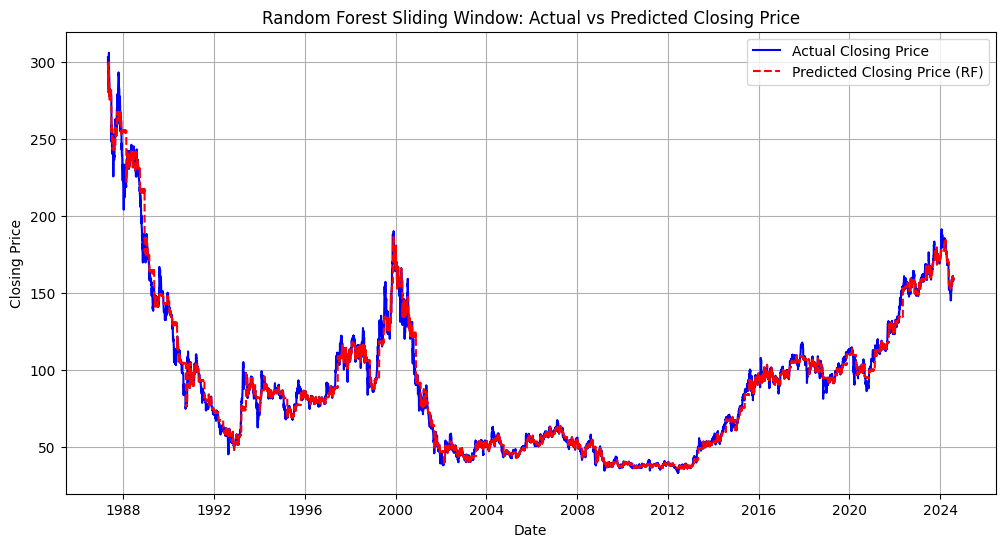

In [28]:
# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actual_values_rf):], actual_values_rf, label="Actual Closing Price", color="blue")
plt.plot(df.index[-len(predictions_rf):], predictions_rf, label="Predicted Closing Price (RF)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Random Forest Sliding Window: Actual vs Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# **LSTMモデルを構築**
* データをスライディングウィンドウ形式で準備
* 学習（50日間のデータを学習し、次の50日を予測）
* 予測結果の可視化
* モデル評価（RMSEを計算）

# **LSTM予測モデルの説明**
**データの前処理**
* MinMaxScaler を使ってスケール変換（LSTMは正規化データの方が学習しやすいため）
* 50日間のデータを学習し、次の50日を予測するスライディングウィンドウ方式

**LSTMモデル（デフォルトの設定、以下のパラメータで開始）**
* LSTM層（50ユニット, ReLU活性化）
* Dense層（出力50日分）
* 損失関数: MSE
* 最適化: Adam
* 20エポック で学習


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import Dropout
from sklearn.preprocessing import MinMaxScaler

# 特徴量のスケーリング（LSTMはスケールされたデータの方が学習しやすい）
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# ウィンドウサイズ（学習期間）と予測期間を設定
window_size = 50  # 学習期間
forecast_horizon = 50  # 予測期間

# RMSEを記録するリスト
rmse_list_lstm = []

# 予測結果を保存するリスト
predictions_lstm = []
actual_values_lstm = []

# 説明変数（特徴量）と目的変数の設定
feature_columns = ["Opening_Price", "Highest_Price", "Lowest_Price", "Volume", "Rate_of_Change%"]
target_column = "Closing_Price"

# スライディングウィンドウでデータを準備
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []

for start in range(0, len(df) - window_size - forecast_horizon, forecast_horizon):
    # 学習データ
    train_X = df_scaled.iloc[start:start + window_size][feature_columns].values
    train_y = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][target_column].values

    # テストデータ
    test_X = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][feature_columns].values
    test_y = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][target_column].values

    # LSTMの入力形式に変換 (サンプル数, タイムステップ数, 特徴量数)
    X_train_list.append(train_X.reshape(1, window_size, len(feature_columns)))
    y_train_list.append(train_y.reshape(1, forecast_horizon))
    X_test_list.append(test_X.reshape(1, forecast_horizon, len(feature_columns)))
    y_test_list.append(test_y.reshape(1, forecast_horizon))

# 配列に変換
X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.vstack(y_test_list)

# LSTMモデルの構築
#model_lstm = Sequential([
#    LSTM(50, activation='relu', input_shape=(window_size, len(feature_columns)), return_sequences=False),
#    Dense(forecast_horizon)  # 50日分の終値を同時に出力
#])
# RMSE=8.791841629537403
model_lstm = Sequential([
    LSTM(200, activation='tanh', input_shape=(window_size, len(feature_columns)), return_sequences=True), # Change to return_sequences=True
    Dropout(0.2),
    LSTM(100, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(forecast_horizon)  # 50日分の終値を同時に出力
])

# モデルのコンパイル
# model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# LSTMの学習
# model_lstm.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 予測
predictions_lstm_scaled = model_lstm.predict(X_test)

# 予測値を元のスケールに戻す
predictions_lstm = []
for i in range(len(predictions_lstm_scaled)):
    # Get the original scaled data for the current window
    original_scaled_window = df_scaled.iloc[i * forecast_horizon : (i + 1) * forecast_horizon].copy()
    # Replace the target column with the reshaped predictions
    original_scaled_window[target_column] = predictions_lstm_scaled[i]
    # Inverse transform the entire window
    inverse_transformed_window = scaler.inverse_transform(original_scaled_window)
    # Extract the target column (Closing_Price)
    predictions_lstm.extend(inverse_transformed_window[:, df_scaled.columns.get_loc(target_column)])

# actual_values_lstmを元のスケールに戻す
# Correctly calculate the start index for actual_values_lstm:
# start_index_actual should be the index where the first test window starts.
start_index_actual = window_size  #  Start from the end of the first training window
# Slice the original dataframe to get the actual closing prices for all test windows
actual_values_lstm = df[target_column][start_index_actual:start_index_actual + len(predictions_lstm)].values

# RMSEの計算
rmse_lstm = np.sqrt(mean_squared_error(actual_values_lstm, predictions_lstm))
rmse_lstm

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0699
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0187
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0102
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0071
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0080
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0056
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0056
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0047
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0044
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0050
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0045
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0048
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.0038
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0039
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0043
Epoc

8.405337015873227

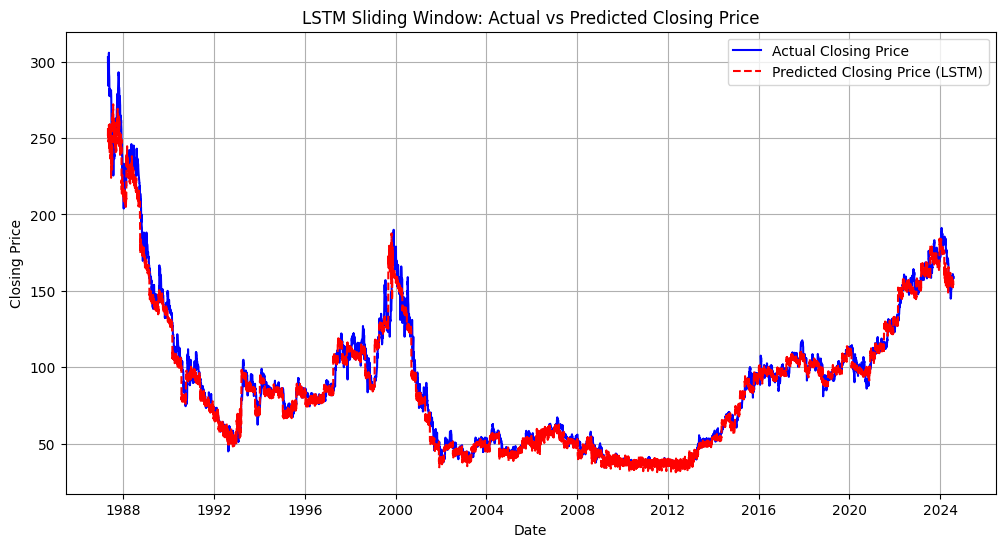

In [38]:
# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actual_values_lstm):], actual_values_lstm, label="Actual Closing Price", color="blue")
plt.plot(df.index[-len(predictions_lstm):], predictions_lstm, label="Predicted Closing Price (LSTM)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("LSTM Sliding Window: Actual vs Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# **特徴量エンジニアリングの結果**

1. 移動平均

 * SMA_7, SMA_30（単純移動平均）
 * EMA_7, EMA_30（指数移動平均）

2. ボリンジャーバンド

 * BB_Mid（20日移動平均）
 * BB_Upper, BB_Lower（±2標準偏差）

3. 出来高の変動

 * Volume_Change（前日比）

4. ラグ特徴量

 * Lag_1, Lag_7, Lag_30（1日、7日、30日前の株価）

5. RSI（Relative Strength Index）

 * 株価の過熱感を示す指標（RSI < 30 なら売られ過ぎ、RSI > 70 なら買われ過ぎ）

6. MACD（移動平均収束拡散）

 * MACD（12日EMA - 26日EMA）
 * Signal_Line（MACDの9日EMA）

In [51]:
# Assume tools is meant to use display
from IPython.display import display

# 特徴量エンジニアリング
# 1. 移動平均（SMA, EMA）
df["SMA_7"] = df["Closing_Price"].rolling(window=7).mean()
df["SMA_30"] = df["Closing_Price"].rolling(window=30).mean()
df["EMA_7"] = df["Closing_Price"].ewm(span=7, adjust=False).mean()
df["EMA_30"] = df["Closing_Price"].ewm(span=30, adjust=False).mean()

# 2. ボリンジャーバンド (20日移動平均 ± 2標準偏差)
df["BB_Mid"] = df["Closing_Price"].rolling(window=20).mean()
df["BB_Upper"] = df["BB_Mid"] + 2 * df["Closing_Price"].rolling(window=20).std()
df["BB_Lower"] = df["BB_Mid"] - 2 * df["Closing_Price"].rolling(window=20).std()

# 3. 出来高変動率（前日比）
df["Volume_Change"] = df["Volume"].pct_change()

# 4. 株価のラグ特徴量（1日, 7日, 30日）
df["Lag_1"] = df["Closing_Price"].shift(1)
df["Lag_7"] = df["Closing_Price"].shift(7)
df["Lag_30"] = df["Closing_Price"].shift(30)

# 5. RSI（相対力指数）計算
window_length = 14
delta = df["Closing_Price"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# 6. MACD（移動平均収束拡散）
ema_12 = df["Closing_Price"].ewm(span=12, adjust=False).mean()
ema_26 = df["Closing_Price"].ewm(span=26, adjust=False).mean()
df["MACD"] = ema_12 - ema_26
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

# 作成した特徴量を確認
# Assuming tools.display_dataframe_to_user was meant to display the dataframe
print("Feature Engineered Stock Data") # Added a title for clarity
display(df.tail(30)) # Using display to show the dataframe

Feature Engineered Stock Data


,Closing_Price,Opening_Price,Highest_Price,Lowest_Price,Volume,Rate_of_Change%,7Days_Moving_average,30Days_Moving_average,SMA_7,SMA_30,...,BB_Mid,BB_Upper,BB_Lower,Volume_Change,Lag_1,Lag_7,Lag_30,RSI,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-20,146.0,145.7,146.6,145.3,174170000.0,0.27,146.328571,152.206667,146.328571,152.206667,...,150.470,157.466571,143.473429,-0.126749,145.6,150.2,167.9,20.979021,-4.002224,-4.052770
2024-06-21,147.0,146.0,148.6,146.0,244110000.0,0.68,146.185714,151.696667,146.185714,151.696667,...,150.190,157.275315,143.104685,0.401562,146.0,148.0,162.3,22.602740,-3.793979,-4.001012
2024-06-24,149.4,148.0,149.5,147.5,213450000.0,1.63,146.414286,151.336667,146.414286,151.336667,...,149.870,156.448466,143.291534,-0.125599,147.0,147.8,160.2,35.185185,-3.396134,-3.880036
2024-06-25,150.9,149.4,150.9,148.6,210780000.0,1.00,147.042857,151.050000,147.042857,151.050000,...,149.725,156.062150,143.387850,-0.012509,149.4,146.5,159.5,45.000000,-2.926072,-3.689243
2024-06-26,151.3,151.0,151.4,149.3,211790000.0,0.27,147.957143,150.870000,147.957143,150.870000,...,149.690,155.981816,143.398184,0.004792,150.9,144.9,156.7,50.000000,-2.492536,-3.449902
2024-06-27,151.3,150.4,151.3,149.7,210600000.0,0.00,148.785714,150.780000,148.785714,150.780000,...,149.645,155.873787,143.416213,-0.005619,151.3,145.5,154.0,54.676259,-2.124465,-3.184815
2024-06-28,151.8,151.9,153.5,151.6,243810000.0,0.33,149.671429,150.780000,149.671429,150.780000,...,149.520,155.448557,143.591443,0.157692,151.3,145.6,151.8,52.272727,-1.771994,-2.902251
2024-07-01,156.2,154.1,156.4,153.2,285900000.0,2.90,151.128571,150.926667,151.128571,150.926667,...,149.580,155.760990,143.399010,0.172634,151.8,146.0,151.8,68.072289,-1.124651,-2.546731
2024-07-02,156.2,157.0,157.1,155.3,258890000.0,0.00,152.442857,151.026667,152.442857,151.026667,...,149.680,156.229440,143.130560,-0.094474,156.2,147.0,153.2,78.472222,-0.604657,-2.158316


Random Forest Model RMSE: 3.9340601811026397


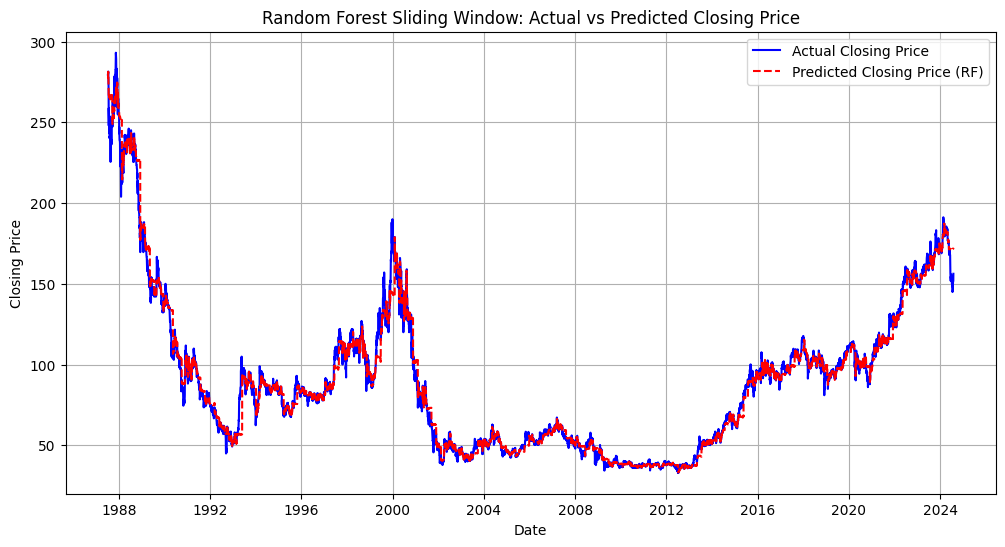

In [57]:
# 特徴量とターゲットのカラム
feature_columns_extended = [
    "Opening_Price", "Highest_Price", "Lowest_Price", "Volume", "Rate_of_Change%",
    "SMA_7", "SMA_30", "EMA_7", "EMA_30", "BB_Mid", "BB_Upper", "BB_Lower",
    "Volume_Change", "Lag_1", "Lag_7", "Lag_30", "RSI", "MACD", "Signal_Line"
]

# NaNを含む行を削除（移動平均やラグ特徴量の影響で最初の数行はNaNになる）
df_cleaned = df.dropna()

# スライディングウィンドウの設定
window_size = 50  # 学習期間
forecast_horizon = 50  # 予測期間

# RMSEを記録するリスト
rmse_list_rf_ext = []

# 予測結果を保存するリスト
predictions_rf_ext = []
actual_values_rf_ext = []

# スライディングウィンドウで学習と予測を繰り返す
for start in range(0, len(df_cleaned) - window_size - forecast_horizon, forecast_horizon):
    # 学習データ
    train_X = df_cleaned.iloc[start:start + window_size][feature_columns_extended]
    train_y = df_cleaned.iloc[start:start + window_size]["Closing_Price"]

    # テストデータ（次の50日間）
    test_X = df_cleaned.iloc[start + window_size:start + window_size + forecast_horizon][feature_columns_extended]
    test_y = df_cleaned.iloc[start + window_size:start + window_size + forecast_horizon]["Closing_Price"]

    # ランダムフォレスト回帰モデルを訓練
    model_rf_ext = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf_ext.fit(train_X, train_y)

    # 50日間の予測
    forecast_rf_ext = model_rf_ext.predict(test_X)

    # RMSEの計算
    rmse_rf_ext = np.sqrt(mean_squared_error(test_y, forecast_rf_ext))
    rmse_list_rf_ext.append(rmse_rf_ext)

    # 予測結果を保存
    predictions_rf_ext.extend(forecast_rf_ext)
    actual_values_rf_ext.extend(test_y)

# 平均RMSEを計算
average_rmse_rf_ext = np.mean(rmse_list_rf_ext)
print(f"Random Forest Model RMSE: {average_rmse_rf_ext}")

# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.index[-len(actual_values_rf_ext):], actual_values_rf_ext, label="Actual Closing Price", color="blue")
plt.plot(df_cleaned.index[-len(predictions_rf_ext):], predictions_rf_ext, label="Predicted Closing Price (RF)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Random Forest Sliding Window: Actual vs Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.show()

y_train min: -1.1730735919775304
y_train max: 3.9825784600825016
y_train mean: -0.034178768316690235


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.6132
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1258
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0626
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0343
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.0633
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0597
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0508
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0338
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0337
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0240
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0241
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.0499
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0352
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0328
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss:

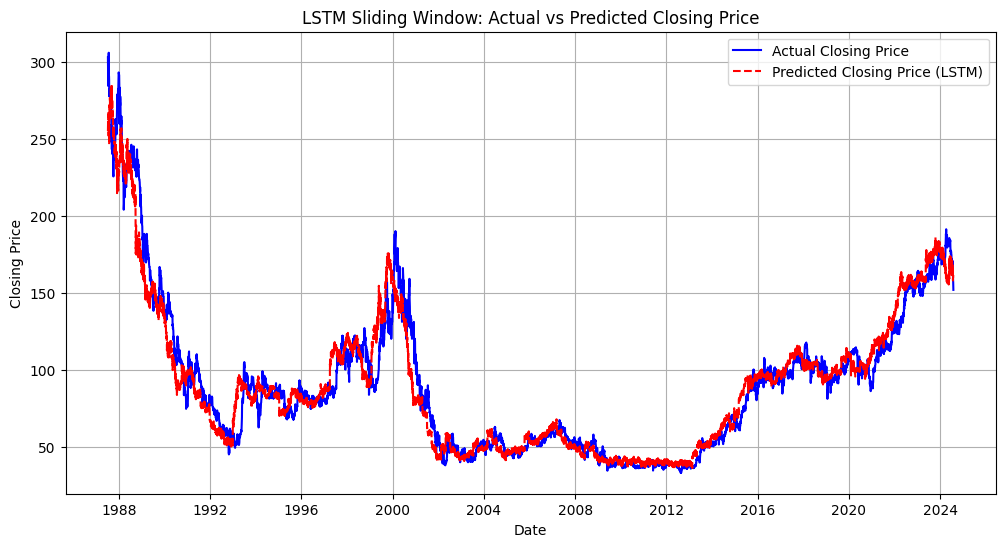

In [60]:
from sklearn.preprocessing import StandardScaler

# 特徴量とターゲットのカラム
feature_columns_extended = [
    "Opening_Price", "Highest_Price", "Lowest_Price", "Volume", "Rate_of_Change%",
    "SMA_7", "SMA_30", "EMA_7", "EMA_30", "BB_Mid", "BB_Upper", "BB_Lower",
    "Volume_Change", "Lag_1", "Lag_7", "Lag_30", "RSI", "MACD", "Signal_Line"
]
target_column = "Closing_Price"

# データのスケーリング（MinMaxScaler → StandardScaler に変更）
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# NaNを削除（重要！）
df_scaled = df_scaled.dropna()

# スライディングウィンドウの設定
window_size = 50  # 学習期間
forecast_horizon = 50  # 予測期間

# スライディングウィンドウでデータを準備
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []
for start in range(0, len(df_scaled) - window_size - forecast_horizon, forecast_horizon):
    train_X = df_scaled.iloc[start:start + window_size][feature_columns_extended].values
    train_y = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][target_column].values
    test_X = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][feature_columns_extended].values
    test_y = df_scaled.iloc[start + window_size:start + window_size + forecast_horizon][target_column].values

    X_train_list.append(train_X.reshape(1, window_size, len(feature_columns_extended)))
    y_train_list.append(train_y.reshape(1, forecast_horizon))
    X_test_list.append(test_X.reshape(1, forecast_horizon, len(feature_columns_extended)))
    y_test_list.append(test_y.reshape(1, forecast_horizon))

# 配列に変換
X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.vstack(y_test_list)

# y_train の異常値チェック
print("y_train min:", np.min(y_train))
print("y_train max:", np.max(y_train))
print("y_train mean:", np.mean(y_train))

# LSTMモデルの構築（修正）
model_lstm = Sequential([
    LSTM(200, activation='tanh', return_sequences=True, input_shape=(window_size, len(feature_columns_extended))),
    Dropout(0.1),  # Dropoutを0.1に変更
    LSTM(100, activation='tanh', return_sequences=False),
    Dense(forecast_horizon)
])

# モデルのコンパイル（学習率調整）
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# LSTMの学習
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 予測
predictions_lstm_scaled = model_lstm.predict(X_test)

# 予測値を元のスケールに戻す
predictions_lstm = []
for i in range(len(predictions_lstm_scaled)):
    original_scaled_window = df_scaled.iloc[i * forecast_horizon : (i + 1) * forecast_horizon].copy()
    original_scaled_window[target_column] = predictions_lstm_scaled[i]
    inverse_transformed_window = scaler.inverse_transform(original_scaled_window)
    predictions_lstm.extend(inverse_transformed_window[:, df_scaled.columns.get_loc(target_column)])

# actual_values_lstmを元のスケールに戻す
start_index_actual = window_size
actual_values_lstm = df[target_column][start_index_actual:start_index_actual + len(predictions_lstm)].values

# RMSEの計算
rmse_lstm = np.sqrt(mean_squared_error(actual_values_lstm, predictions_lstm))
print(f"LSTM Model RMSE: {rmse_lstm}")

# 予測結果のプロット
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actual_values_lstm):], actual_values_lstm, label="Actual Closing Price", color="blue")
plt.plot(df.index[-len(predictions_lstm):], predictions_lstm, label="Predicted Closing Price (LSTM)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("LSTM Sliding Window: Actual vs Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.show()